<center><h2>Setup - Environment & Dependencies</center></h2>

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import modf
from scipy import stats

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
surface = pd.read_csv('ttc_surface_route_delays.csv')
weather = pd.read_csv('weather.csv')
holidays = pd.read_csv('holidays.csv')

In [3]:
surface['Report Date'] = pd.to_datetime(surface['Report Date'])
surface['Month'] = surface['Report Date'].dt.month
surface['nDay'] = surface['Report Date'].dt.day
surface = surface.rename(columns={'Report Date': 'Date'})
surface = surface.drop(columns=['Unnamed: 0'])

weather['Date/Time'] = pd.to_datetime(weather['Date/Time'])
weather = weather.rename(columns={
    'Date/Time': 'Date', 
    'Mean Temp (°C)': 'Mean Temp', 
    'Total Precip (mm)': 'Precipitation'
})
weather = weather.drop(columns={'Year', 'Month', 'Day'})

holidays = holidays.rename(columns={'date': 'Date', 'holiday': 'Holiday'})
holidays['Date'] = pd.to_datetime(holidays['Date'])

surface = pd.merge(surface, weather, on ='Date', how='left')
surface = pd.merge(surface, holidays, on ='Date', how='left')

surface['Holiday'] = surface['Holiday'].fillna('None')

surface = surface[surface['Min Delay'] < 7000]
surface['Route'] = surface['Route'].astype('category')
surface['Vehicle'] = surface['Vehicle'].astype('category')

surface['Incident'] = surface['Incident'].replace({
    'Late Leaving Garage - Mechanical': 'Late Leaving Garage',
    'Late Leaving Garage - Operator': 'Late Leaving Garage',
    'Late Leaving Garage - Management': 'Late Leaving Garage'
})

surface = surface[(surface['Min Delay'] >= 0) & (surface['Min Delay'] <= 30)]

In [ ]:
#surface.to_csv('surface_master.csv')

In [ ]:
surface.sort_values('Min Delay').head(15)

In [ ]:
holidays.head()

In [ ]:
weather.head()

In [ ]:
surface.info()

<center><h2>Impact of Precipitation on Minutes Delayed by Route</center></h2>

In [137]:
routes = surface.groupby(['Date', 'Route']).agg({'Min Delay': 'sum', 'Precipitation': 'sum'}).reset_index()

routes_precip = routes[routes['Precipitation'] > 10]

routes_precip = routes_precip.sample(100)

### Histogram of Surface Routes - Minutes Delayed

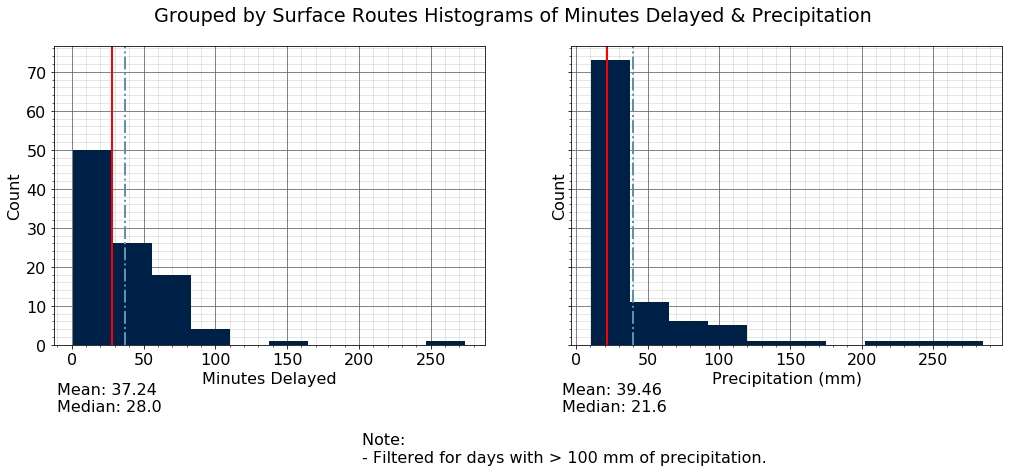

In [148]:
route_mean_min = routes_precip['Min Delay'].mean()
route_median_min = routes_precip['Min Delay'].median()
route_mean_precip = routes_precip['Precipitation'].mean()
route_median_precip = routes_precip['Precipitation'].median()

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = [17, 5.5])

# Plot 1
ax = axs[0]
ax.hist(
    routes_precip['Min Delay'], 
    bins = 10,
    color = '#002147'
)

ax.axvline(
    route_mean_min, 
    lw = 2, 
    color = '#5F90B2',
    ls = '-.'
)

ax.axvline(
    route_median_min, 
    lw = 2, 
    color = 'red'
)

ax.set_ylabel('Count')
ax.set_xlabel('Minutes Delayed')

ax.text(-10, -17, f'Mean: {round(route_mean_min, 2)} \
                    \nMedian: {round(route_median_min, 2)}')
ax.grid(
    b = True, 
    which = 'major', 
    color = '#666666', 
    linestyle = '-'
)

ax.minorticks_on()
ax.grid(
    b = True, 
    which = 'minor', 
    color = '#666666', 
    linestyle = '-', 
    alpha = 0.2
)

# Plot 2
ax = axs[1]

ax.hist(
    routes_precip['Precipitation'], 
    bins = 10, 
    color = '#002147'
)

ax.axvline(
    route_mean_precip, 
    lw = 2, 
    color = '#5F90B2',
    ls = '-.'
)

ax.axvline(
    route_median_precip, 
    lw = 2, 
    color = 'red'
)

ax.set_ylabel('Count')
ax.set_xlabel('Precipitation (mm)')

ax.text(-10, -17, f'Mean: {round(route_mean_precip, 2)} \
                    \nMedian: {round(route_median_precip, 2)}')

ax.grid(
    b = True, 
    which = 'major', 
    color = '#666666', 
    linestyle = '-'
)

ax.minorticks_on()
ax.grid(
    b = True, 
    which = 'minor', 
    color = '#666666', 
    linestyle = '-', 
    alpha = 0.2
)

fig.suptitle('Grouped by Surface Routes Histograms of Minutes Delayed & Precipitation')
plt.text(-150, -30, 'Note: \n- Filtered for days with > 100 mm of precipitation.')

plt.savefig('TTC Surface Route Histograms (Min Delay, Precipitation).png')
plt.show()

### Linear Regression - Surface Routes: Precipitation vs. Minutes Delayed

In [139]:
x = routes_precip['Precipitation']
y = routes_precip['Min Delay']

slope, intercept, rvalue, pvalue, std_err = stats.linregress(x, y)
fit = slope * x + intercept

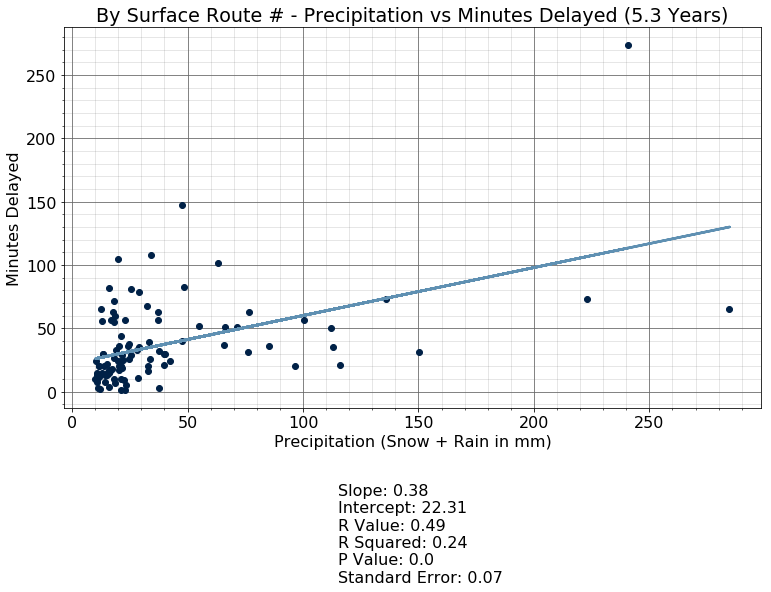

In [150]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    routes_precip['Precipitation'], 
    routes_precip['Min Delay'],
    color = '#002147'
)

ax.plot(routes_precip['Precipitation'], fit, color = '#5F90B2', linewidth = 2.5)

ax.set_ylabel('Minutes Delayed')
ax.set_xlabel('Precipitation (Snow + Rain in mm)')
ax.set_title('By Surface Route # - Precipitation vs Minutes Delayed (5.3 Years)')

plt.grid(which = 'major', color = '#666666', linestyle = '-')
plt.minorticks_on()
plt.grid(which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.text(115, -150, f'Slope: {round(slope, 2)} \
                    \nIntercept: {round(intercept, 2)} \
                    \nR Value: {round(rvalue, 2)} \
                    \nR Squared: {round(rvalue**2, 2)} \
                    \nP Value: {round(pvalue, 2)} \
                    \nStandard Error: {round(std_err, 2)}')

plt.show()

<center><h2>Exploratory Scatterplot</center</h2>

In [ ]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    surface['Precipitation'], 
    surface['Min Delay'], 
    c=surface['Mean Temp'], 
    alpha = 0.5
)

ax.set_ylabel('Minutes')
ax.set_xlabel('Daily Precipitation')
ax.set_title('Surface Routes - Temperature vs. Minutes Delayed')

plt.text(-30, -2000, 'Note: \
                    \n- Temperature in degrees celsius. \
                    \n- Outlier of 246245 (2014-03-03) minutes delayed removed. \
                    \n- Colored by Mean Temperature per Day')

plt.tight_layout()
plt.savefig('Surface Routes - Temperature vs. Minutes Delayed.png')
plt.show()

In [ ]:
vehicles = surface.groupby(['Date', 'Route', 'Vehicle']).agg({'Min Delay': 'sum', 'Min Gap': 'sum', 'Precipitation': 'sum'})
vehicles = vehicles.rename(columns={'Min Delay': 'Total Minutes', 'Min Gap': 'Total Gap'}).reset_index()
vehicles.head(10)

In [ ]:
vehicles['Total Minutes'].mean(), vehicles['Total Gap'].mean()

In [ ]:
vehicles = vehicles[vehicles['Total Minutes'] < 200]

fig, ax = plt.subplots(1, figsize=[12.5, 7])

ax.hist(vehicles['Total Minutes'], bins = 100)

plt.show()

<center><h2>Delay Time</h2></center>

In [ ]:
groupedbyday = surface.groupby(['Date', 'Day']).agg({'Min Delay': 'sum'})
groupedbyday = groupedbyday.reset_index()
groupedbyday

In [ ]:


fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.hist(groupedbyday['Min Delay'], bins = 100)

plt.show()

In [ ]:
groupedbyday.mean(), groupedbyday.median()

In [ ]:
totaldays = len(groupedbyday)
totalmin = groupedbyday['Min Delay'].sum()
meanminperday = round(groupedbyday['Min Delay'].mean(), 2)
medianminperday = round(groupedbyday['Min Delay'].median(), 2)
daysdelay = round((groupedbyday['Min Delay'].sum()/60)/24, 2)
percdelay = round((daysdelay / totaldays)/100, 2)
sigmaday = round(groupedbyday['Min Delay'].std(), 2)
delayvariance = round(sigmaday ** 2, 2)

delaystats_dict = {
    'Total Days': totaldays,
    'Total Minutes': daysdelay,
    'Mean Min. per Day': meanminperday,
    'Median Min. per Day': medianminperday,
    '% of Days Delayed': percdelay,
    'Daily Sigma': sigmaday,
    'Delay Variance': delayvariance
}

delaystats = pd.DataFrame(delaystats_dict, index=['Stats'])

delaystats = delaystats.style.format({
    '% of Days Delayed': '{:.2%}'.format
})

In [ ]:
totaldays, totalmin, meanminperday, medianminperday, daysdelay, percdelay, sigmaday, delayvariance

In [ ]:
delaystats

In [ ]:
surface.head()

In [ ]:
incidents = surface.groupby('Incident').agg({'Min Delay': 'sum', 'Min Gap': 'sum'}).sort_values('Min Delay')
incidents = incidents.reset_index()
incidents

In [ ]:
names = incidents['Incident'].unique().tolist()
names

In [ ]:
bar1 = weekdays['Min Delay']
bar2 = weekdays['Min Gap']

label = weekdays['Day']
barwidth = 1
names = weekdays['Day'].unique().tolist()
dayorder = [1, 5, 6, 4, 0, 2, 3]
names = [names[i] for i in dayorder]

In [ ]:
bar1 = incidents['Min Delay']
bar2 = incidents['Min Gap']

label = incidents['Incident']
barwidth = 1

description = incidents['Incident'].unique().tolist()
description_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
descriptions = [description[i] for i in description_order]

bars = np.add(bar1, bar2).tolist()

fig, ax = plt.subplots(1, figsize = [12.5, 10])

p1 = ax.bar(label, bar1, color='#800000', edgecolor='white', width=barwidth)
p2 = ax.bar(label, bar2, bottom=bar1, color='#888888', edgecolor='white', width=barwidth)

ax.set_ylabel('Minutes')
ax.set_xlabel('Days of the Week')
ax.set_title('Sum of Minutes per Delay Description')

plt.legend((p1[0], p2[0]), ('Minutes Delayed', 'Gap in Minutes'))

plt.xticks(label, descriptions, rotation = 35)

plt.tight_layout()

plt.savefig('Sum of Minutes per Delay Description.png')
plt.show()

<center><h2>Time of Day</center></h2>

In [ ]:
surface.head()

In [ ]:
surface.info()

In [ ]:
surface.head()

In [ ]:

dailyincidents.head()

In [ ]:
timeofday = surface.groupby(['Day', 'Time']).agg({'Min Delay': 'sum'}).reset_index()
timeofday = timeofday[timeofday['Time'] < 24]
timeofday['Hour'] = round(((timeofday['Time'] / 1) * 60) / 60, 0)
dailyincidents = surface.groupby(['Day', 'Time']).agg({'Min Delay': 'count'}).reset_index()
dailyincidents = dailyincidents.rename(columns={'Min Delay': 'Counts'})
timeofday['Counts'] = dailyincidents['Counts']

timeofday.head()

In [ ]:
weeklysum = timeofday.groupby(['Day', 'Hour']).agg({'Min Delay': 'sum', 'Counts': 'sum'}).reset_index().reset_index()
weeklysum = weeklysum.rename(columns={'index': 'Chronological', 'Min Delay': 'Min Sum'})
minmean = timeofday.groupby(['Day', 'Hour']).agg({'Min Delay': 'mean'}).rename(columns={'Min Delay': 'Min Mean'}).reset_index()
weeklysum['Min Mean'] = round(minmean['Min Mean'], 2)


weeklysum.tail()

In [ ]:
weeklysum.head()

In [ ]:
ticks = [12, 36, 65, 90, 115, 140, 165]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.plot(
    weeklysum['Chronological'], 
    weeklysum['Min Mean'],
    c = '#5d0000',
    linewidth = 4
)

plt.xticks(ticks = ticks, labels = labels)


plt.show()

### Incidents

In [ ]:
surface.head()

In [ ]:
incidents = surface.groupby(['Incident']).agg({'Min Delay': 'sum', 'Precipitation': 'sum'}).reset_index()
incidents

In [ ]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.bar(incidents['Incident'], incidents['Min Delay'])

plt.xticks(rotation=65)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(incidents['Precipitation'], incidents['Min Delay'])

plt.show()